In [4]:
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, GRU, Dense, Multiply, Add, Concatenate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tensorflow.keras.layers import Lambda

def r2_score_metric(y_true, y_pred):
    """Custom R2 score metric"""
    SS_res = tf.reduce_sum(tf.square(y_true - y_pred)) 
    SS_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true))) 
    return (1 - SS_res / (SS_tot + tf.keras.backend.epsilon()))

In [5]:
def train_and_evaluate_gru_model(target_variable, flag_train=True, _epochs=100, _batch_size=10):
    # Load your data from the Excel file
    mgh_data = pd.read_excel("gru-datasets.xlsx")

    # Select relevant features
    features = ['timesteps', f'{target_variable} (Predicted GL)', f'{target_variable} (Predicted NN)']
    
    X = mgh_data[features]
    y = mgh_data[f'{target_variable} (Actual)']
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

    # Reshape data for GRU input (samples, timesteps, features)
    X_train_reshaped = X_train.values.reshape((X_train.shape[0], -1, X_train.shape[1]))
    X_test_reshaped = X_test.values.reshape((X_test.shape[0], -1, X_test.shape[1]))

    if flag_train:
        # Define the input shapes
        time_steps = X_train_reshaped.shape[1]
        features_count = X_train_reshaped.shape[2]

        # Inputs
        input_layer = Input(shape=(time_steps, features_count), name='input_layer')

        # GRU Layer to process the time series data
        gru_output = GRU(units=64, return_sequences=False)(input_layer)

        # Dense layers to predict w_physics and w_nn
        w_physics = Dense(1, activation='sigmoid')(gru_output)
        w_nn = Lambda(lambda x: 1.0 - x)(w_physics)  # w_nn = 1 - w_physics

        # y_hat calculation based on the predicted weights
        # Extract the q_physics and q_nn inputs from the reshaped input
        q_physics_input = Lambda(lambda x: x[:, :, 1], name='q_physics_input')(input_layer)
        q_nn_input = Lambda(lambda x: x[:, :, 2], name='q_nn_input')(input_layer)

        q_physics_flatten = Lambda(lambda x: tf.squeeze(x, axis=-1))(q_physics_input)
        q_nn_flatten = Lambda(lambda x: tf.squeeze(x, axis=-1))(q_nn_input)

        # y_hat calculation
        y_hat_physics = Multiply()([q_physics_flatten, w_physics])
        y_hat_nn = Multiply()([q_nn_flatten, w_nn])
        y_hat = Add()([y_hat_physics, y_hat_nn])

        # Define the model
        model = Model(inputs=input_layer, outputs=y_hat)

        # Compile the model
        model.compile(optimizer='adam', loss='mse', metrics=['mae', r2_score_metric])

        # Train the model
        history = model.fit(X_train_reshaped, y_train, epochs=_epochs, batch_size=_batch_size, validation_split=0.2, verbose=1)

        # Save the model
        model.save(f'gru-models/{target_variable}_gru_model.keras')

        # Predict the test set
        y_hat_test = model.predict(X_test_reshaped)

    else:
        # Load the model
        loaded_model = load_model(f'gru-models/{target_variable}_gru_model.keras', custom_objects={'r2_score_metric': r2_score_metric})

        # Predict using the loaded model
        y_hat_test = loaded_model.predict(X_test_reshaped)

    # Evaluate the model
    mae = mean_absolute_error(y_test, y_hat_test)
    r2 = r2_score(y_test, y_hat_test)

    if flag_train:
        # Plot training history
        plt.figure(figsize=(6, 4))
        sns.lineplot(x=history.epoch, y=history.history['loss'], color='g', label='training')
        sns.lineplot(x=history.epoch, y=history.history['val_loss'], color='b', label='validation')
        plt.title('Model loss during training')
        plt.ylabel('loss')
        plt.xlabel('training epoch')
        plt.legend(loc='upper right')

        plt.figure(figsize=(6, 4))
        sns.lineplot(x=history.epoch, y=history.history['r2_score_metric'], color='g', label='training')
        sns.lineplot(x=history.epoch, y=history.history['val_r2_score_metric'], color='b', label='validation')
        plt.title('R2 during training')
        plt.ylabel('R2')
        plt.xlabel('epoch')
        plt.legend(loc='lower right')

    print(f"\nTarget Variable: {target_variable}")
    print(f"MAE: {mae:.2f}")
    print(f"R²: {r2:.2f}")

    # Scatter plot of actual vs. predicted values
    plt.figure(figsize=(6, 4))
    plt.scatter(y_test, y_hat_test, label='Predicted vs Actual')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Perfect Prediction')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Actual vs Predicted Values for {target_variable}\nMAE: {mae:.2f}, R²: {r2:.2f}')
    plt.legend()

    # Plot of actual vs. predicted over time
    plt.figure(figsize=(6, 4))
    plt.plot(range(len(y_test)), y_test, marker='o', linestyle='-', color='blue', label='Actual')
    plt.plot(range(len(y_hat_test)), y_hat_test, marker='x', linestyle='--', color='red', label='Predicted')
    plt.title(f'Actual vs Predicted Values for {target_variable}')
    plt.xlabel('Index')
    plt.ylabel(target_variable)
    plt.legend()
    plt.show()


Epoch 1/100
260/260 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1031 - mae: 0.2454 - r2_score_metric: -13.9265 - val_loss: 0.0878 - val_mae: 0.2263 - val_r2_score_metric: 0.4331
Epoch 2/100
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0866 - mae: 0.2301 - r2_score_metric: 0.5289 - val_loss: 0.0868 - val_mae: 0.2236 - val_r2_score_metric: 0.4492
Epoch 3/100
260/260 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0791 - mae: 0.2190 - r2_score_metric: 0.5338 - val_loss: 0.0857 - val_mae: 0.2244 - val_r2_score_metric: 0.4470
Epoch 4/100
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0836 - mae: 0.2236 - r2_score_metric: 0.5231 - val_loss: 0.0855 - val_mae: 0.2227 - val_r2_score_metric: 0.4607
Epoch 5/100
260/260 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0836 - mae: 0.2213 - r2_score_metric: 0.6037 - val_loss: 0.0861 - val_mae: 0.2238 - val_r2_score_metric: 0.4506
Epoch 6/100
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0849 - mae: 0.2225 - r2_score_metric: 0.1193 - val_loss: 0.0

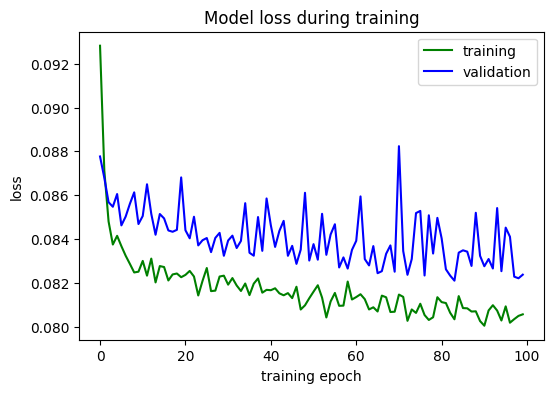

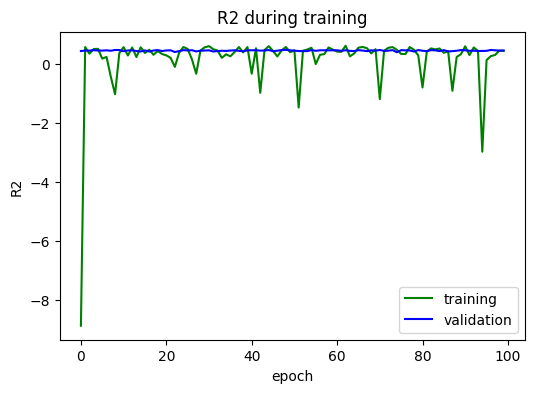

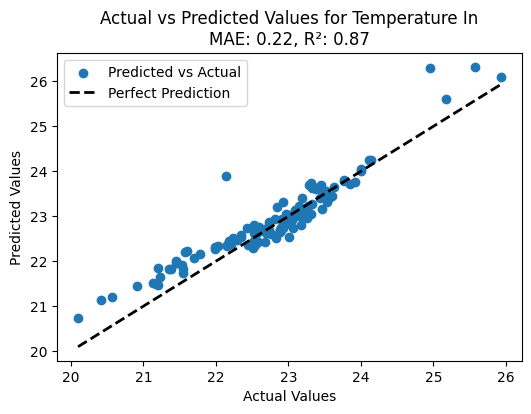

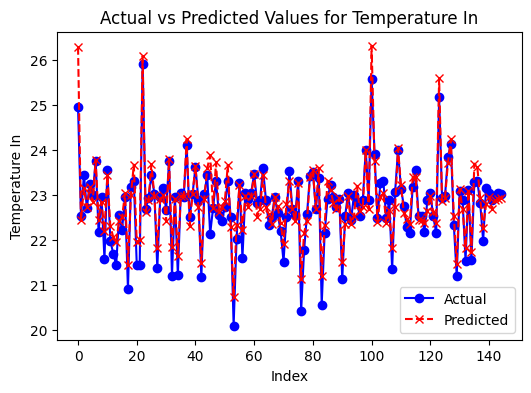

In [6]:
train_and_evaluate_gru_model(target_variable='Temperature In', flag_train=True, _epochs=100, _batch_size=4)

In [7]:
train_and_evaluate_gru_model(target_variable='PAR In', flag_train=True, _epochs=100, _batch_size=4)

Epoch 1/100
260/260 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.7993 - mae: 0.6865 - r2_score_metric: -4.8811 - val_loss: 0.4176 - val_mae: 0.3716 - val_r2_score_metric: 0.5221
Epoch 2/100
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2297 - mae: 0.3322 - r2_score_metric: -20.9805 - val_loss: 0.4160 - val_mae: 0.3668 - val_r2_score_metric: 0.5305
Epoch 3/100
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2413 - mae: 0.3313 - r2_score_metric: 0.5532 - val_loss: 0.4153 - val_mae: 0.3649 - val_r2_score_metric: 0.5356
Epoch 4/100
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2762 - mae: 0.3436 - r2_score_metric: 0.8146 - val_loss: 0.4149 - val_mae: 0.3637 - val_r2_score_metric: 0.5387
Epoch 5/100
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2808 - mae: 0.3547 - r2_score_metric: -33.2653 - val_loss: 0.4146 - val_mae: 0.3631 - val_r2_score_metric: 0.5405
Epoch 6/100
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3366 - mae: 0.3748 - r2_score_metric: 0.6411 - val_loss: 

Epoch 1/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 2970.7522 - mae: 54.4278 - r2_score_metric: -6366.8872 - val_loss: 2885.2947 - val_mae: 53.6424 - val_r2_score_metric: -2786.4373
Epoch 2/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2912.4141 - mae: 53.8985 - r2_score_metric: -4612.4263 - val_loss: 2882.0310 - val_mae: 53.6114 - val_r2_score_metric: -2783.6196
Epoch 3/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2910.1865 - mae: 53.8784 - r2_score_metric: -4661.6235 - val_loss: 2880.0115 - val_mae: 53.5921 - val_r2_score_metric: -2781.9690
Epoch 4/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2907.3862 - mae: 53.8474 - r2_score_metric: -2907.3042 - val_loss: 2879.3101 - val_mae: 53.5856 - val_r2_score_metric: -2781.1956
Epoch 5/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2917.9006 - mae: 53.9532 - r2_score_metric: -6567.3667 - val_loss: 2879.4788 - val_mae: 53.5876 - val_r2_score_metric: -2780.8208
Epoch 6/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 3

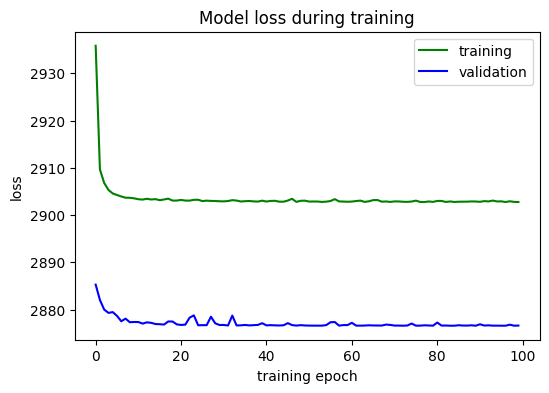

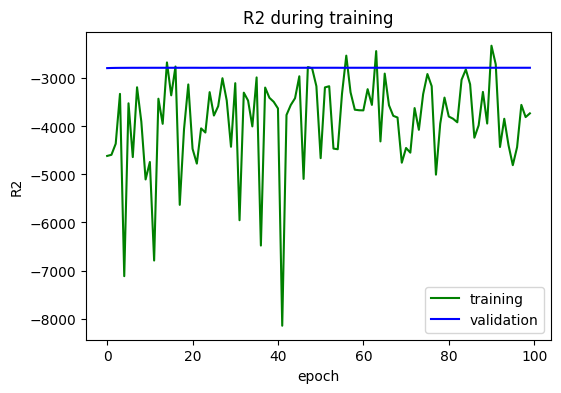

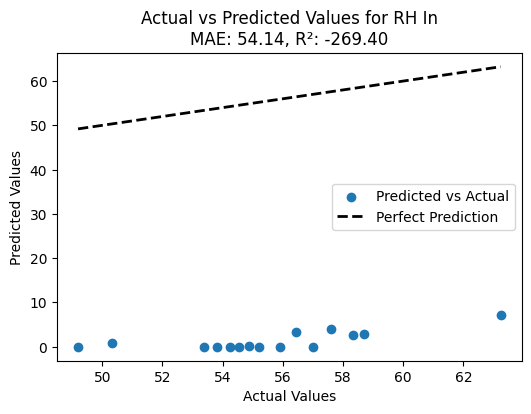

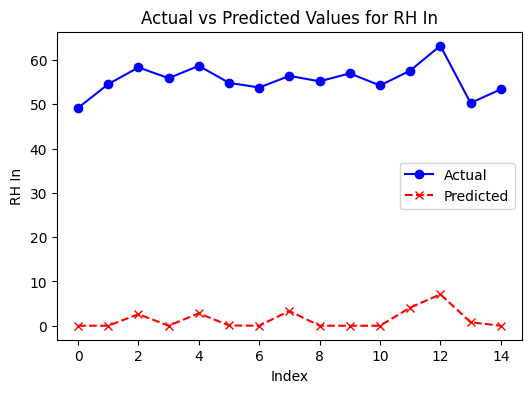

In [ ]:
train_and_evaluate_gru_model(target_variable='RH In', flag_train=True, _epochs=100, _batch_size=4)